# **Jalankan di Kaggle Notebook**

# ***✅ Langkah 1: Import Dataset***

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/sea-animals-image-dataste'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sea-animals-image-dataste/Penguin/13441017033_5f20afed5c_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/6814743888_d76f64e5e5_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/7678547704_88ee08ec1d_b.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/8474798677_0abda01a4a_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/32902414928_2e8353fa26_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/15504936167_e35ed3aff4_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/7034434541_5ce97baae9_b.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/5046498528_ce14576cc5_b.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/8743767793_db72c2194c_b.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/15662693510_45f2cba841_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/8140231806_667fcddb19_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/8265500033_50f71f9aa8_o.jpg
/kaggle/input/sea-animals-image-dataste/Penguin/25979744960_881d0aed86_b.jpg
/kaggle

*Mengecek isi direktori dataset gambar hewan laut untuk memastikan bahwa file dan folder data sudah benar dan siap diproses.*

# ***✅ Langkah 2: Import Library***

In [2]:
# === General Utilities ===
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
from collections import Counter

# === TensorFlow Core ===
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === CNN Architectures ===
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# === Data Augmentation ===
from tensorflow.keras import layers

# === Evaluation Tools ===
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# === Optional (Jupyter settings / warnings) ===
import warnings
warnings.filterwarnings("ignore")



2025-05-04 13:31:33.440324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746365493.644764      70 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746365493.699997      70 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*Mengimpor seluruh library yang diperlukan—mulai dari utilitas umum, model CNN (ResNet50), pemrosesan data, dan evaluasi*

# ***✅ Langkah 3: Load Dataset, Split Train-Test, dan Preprocessing Awal***


In [3]:
# Path dataset sea animals
dataset_path = '/kaggle/input/sea-animals-image-dataste'

# Cek nama kelas di dalam folder
class_names = sorted(os.listdir(dataset_path))
print("Kelas yang ditemukan:", class_names)

Kelas yang ditemukan: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


*Setelah memastikan path dataset sudah benar, langkah ini mengambil nama-nama folder dalam dataset—yang sekaligus menjadi label kelas untuk tugas klasifikasi. Folder diasumsikan masing-masing berisi gambar dari satu jenis hewan laut. Fungsi os.listdir() membaca nama folder di dalam path dataset, kemudian disortir agar urut dan konsisten. Ini penting karena model akan belajar mengasosiasikan gambar dengan label berdasarkan urutan ini.*

In [4]:


# Buat dataset training dan validation
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 13711 files belonging to 23 classes.
Using 10969 files for training.


I0000 00:00:1746365508.760223      70 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 13711 files belonging to 23 classes.
Using 2742 files for validation.


*Dataset dibagi menjadi dua bagian: 80% untuk training dan 20% untuk validasi. Fungsi image_dataset_from_directory() dari TensorFlow sangat praktis untuk langsung membaca gambar dari folder dan mengubahnya menjadi batch siap latih. Ukuran gambar distandarkan ke 224x224 untuk kompatibilitas dengan arsitektur ResNet50.*

In [5]:
class_names = train_data.class_names
num_classes = len(class_names)
print(f"Jumlah kelas: {num_classes}")


Jumlah kelas: 23


*Menyimpan nama-nama kelas dari dataset training dan menghitung jumlah total kelas untuk dipakai dalam pembuatan model.*

# ***✅ Langkah 4: Visualisasi Gambar dan Distribusi Data***

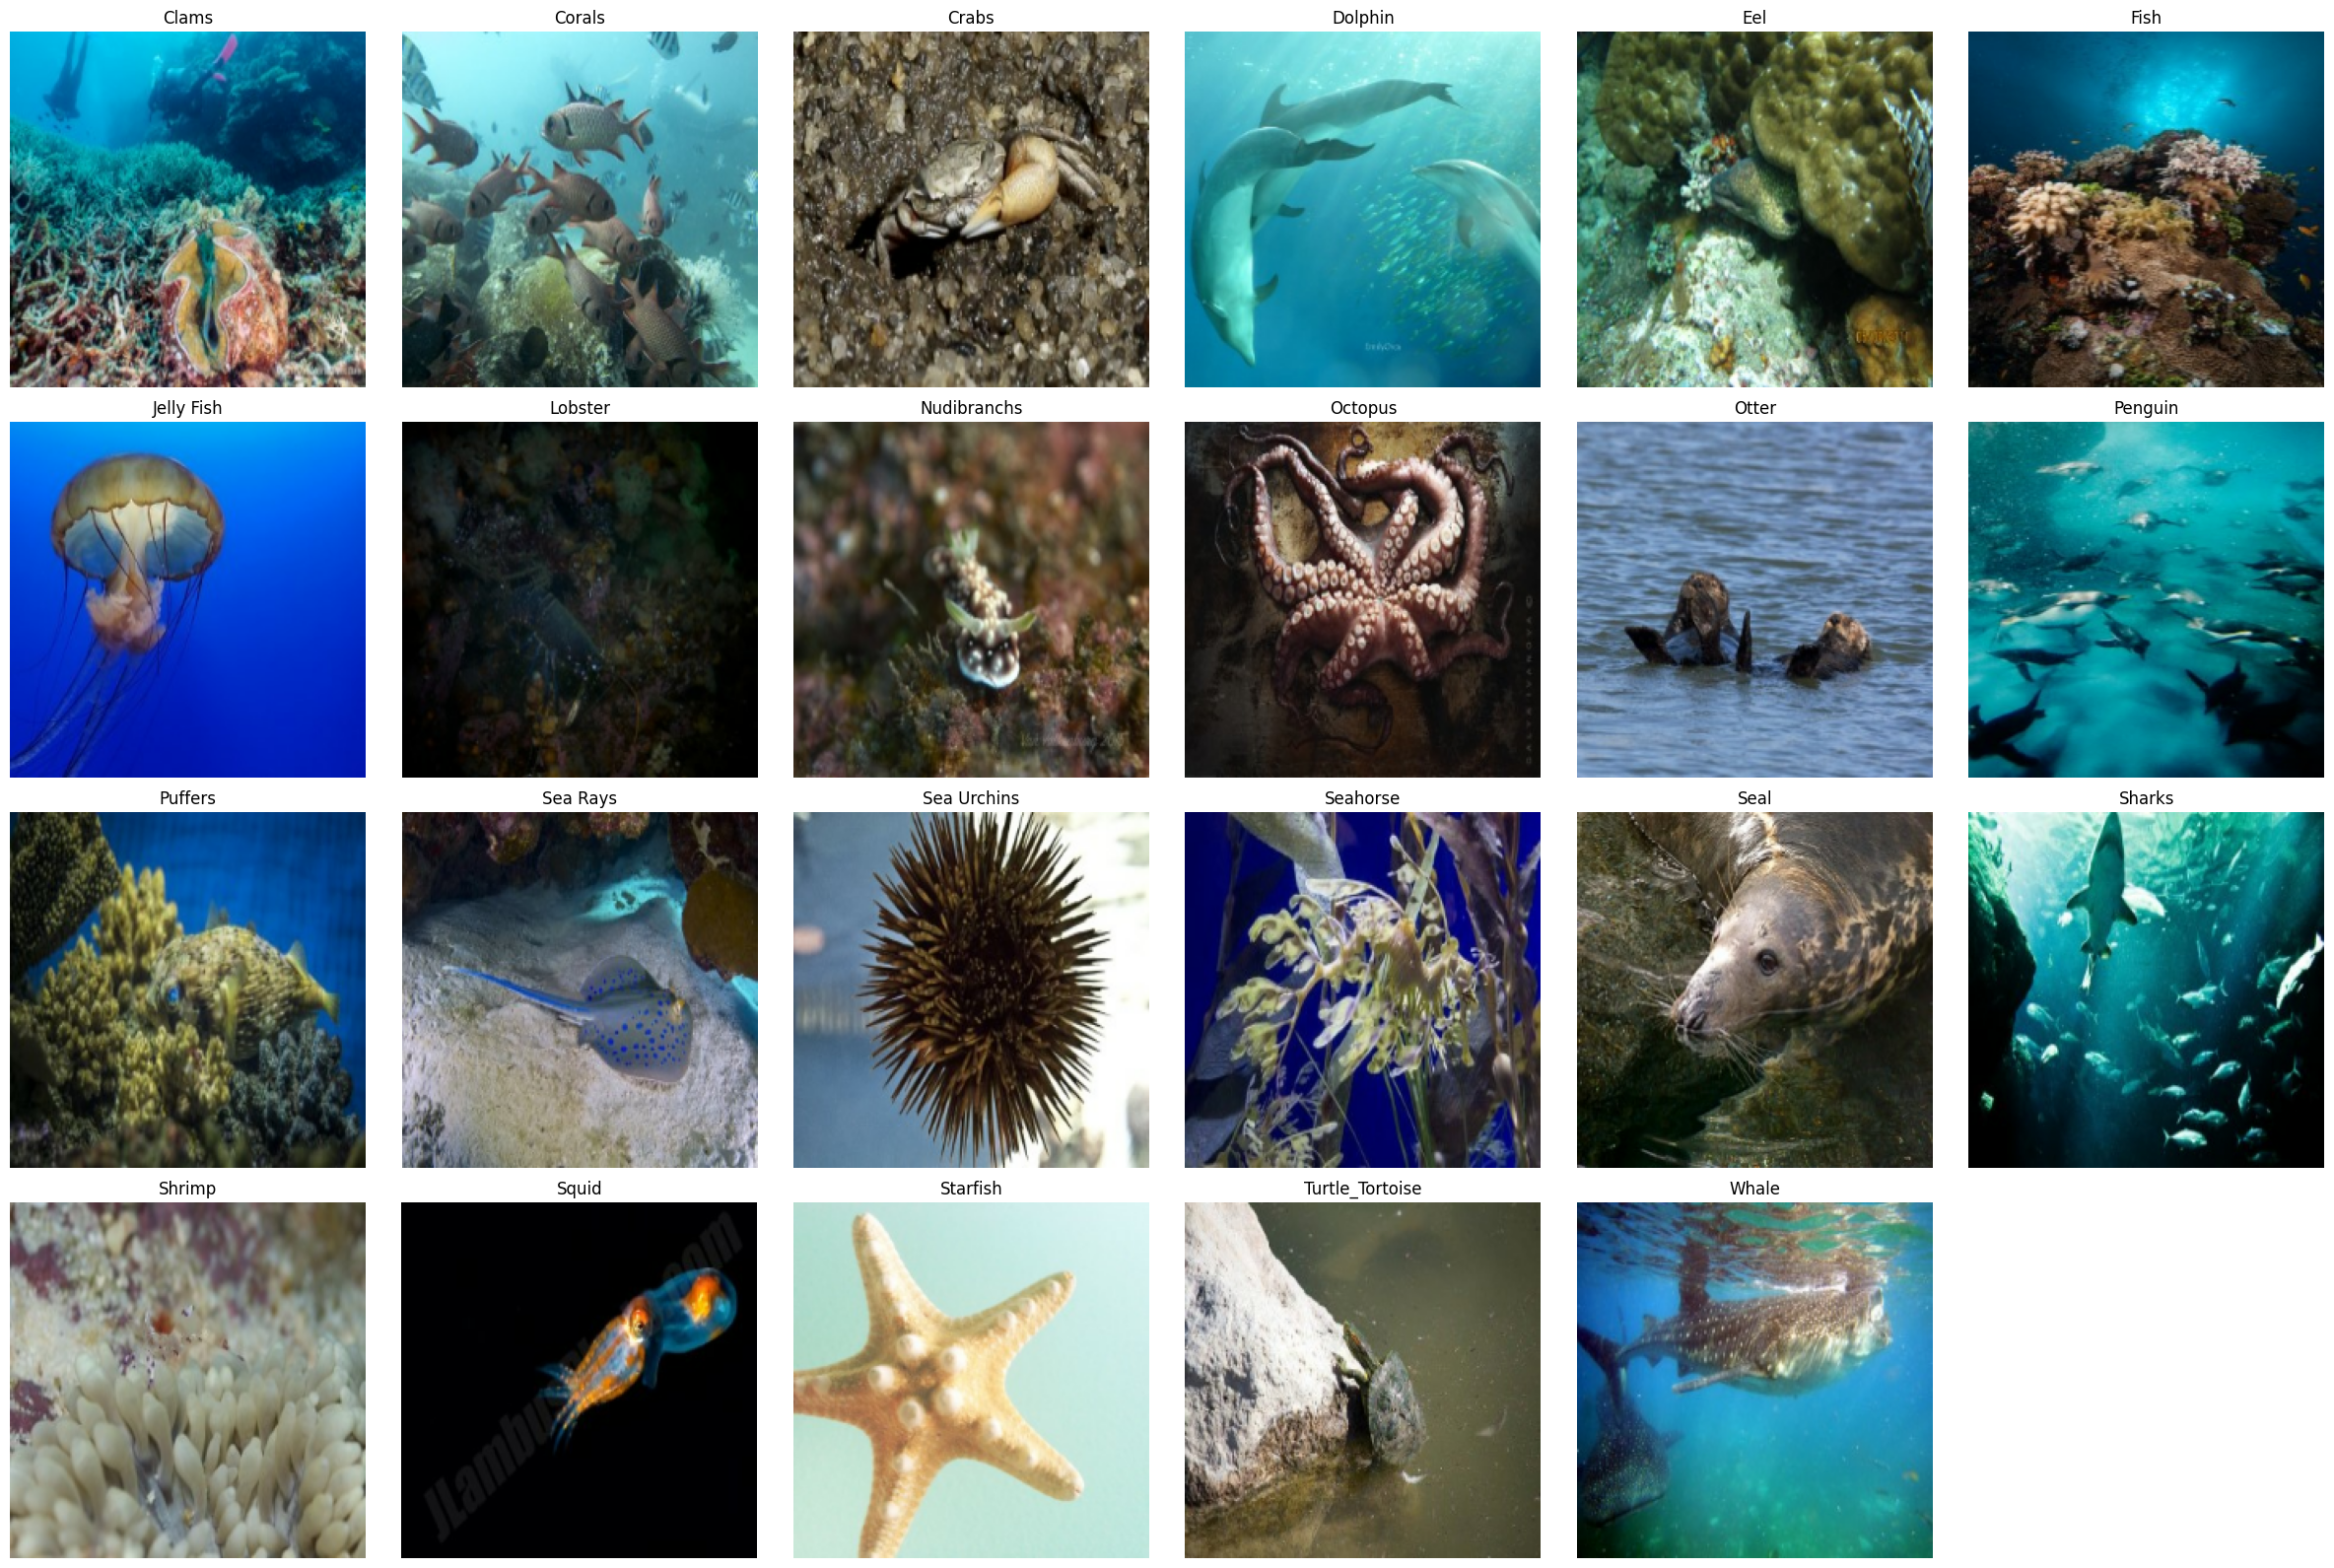

In [6]:


# Ambil class names dari train_data
class_names = train_data.class_names

# Buat dictionary menyimpan 1 sample image per class
sample_images = {class_name: None for class_name in class_names}

# Cari 1 sample dari tiap kelas
for images, labels in train_data.unbatch():
    label = class_names[labels.numpy()]
    if sample_images[label] is None:
        sample_images[label] = images.numpy()
    if all(img is not None for img in sample_images.values()):
        break  # selesai kalau semua kelas sudah terisi

# Plot gambar per kelas
num_classes = len(class_names)
cols = 6
rows = int(np.ceil(num_classes / cols))

plt.figure(figsize=(4 * cols, 4 * rows))
for i, (class_name, img) in enumerate(sample_images.items()):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


*Langkah ini bertujuan untuk menampilkan satu contoh gambar dari masing-masing kelas agar kita bisa memahami representasi visual dari dataset. Pertama-tama, semua gambar pada train_data dibuka satu per satu dengan metode .unbatch(). Lalu, dari setiap kelas, diambil satu gambar yang mewakili dan disimpan dalam dictionary sample_images. Gambar-gambar ini kemudian dipetakan dalam grid menggunakan matplotlib agar terlihat rapi dan mudah dibaca. Langkah ini sangat penting untuk validasi visual bahwa data telah terbaca dengan benar dan label kelas sesuai dengan isi gambarnya.*

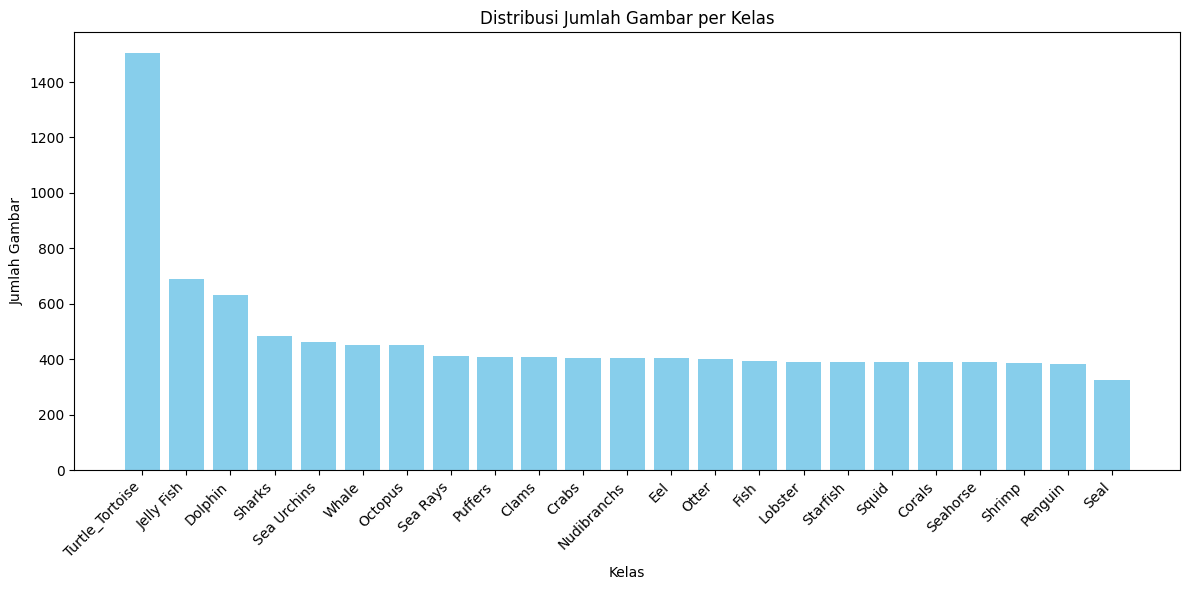

In [7]:

# Hitung jumlah label dari seluruh train_data
all_labels = []

for _, labels in train_data.unbatch():
    all_labels.append(int(labels.numpy()))

label_counts = Counter(all_labels)

# Buat dataframe distribusi
import pandas as pd
df_dist = pd.DataFrame({
    'Label ID': list(label_counts.keys()),
    'Jumlah': list(label_counts.values()),
})
df_dist['Kelas'] = df_dist['Label ID'].map(lambda i: class_names[i])
df_dist = df_dist.sort_values(by='Jumlah', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_dist['Kelas'], df_dist['Jumlah'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.tight_layout()
plt.show()


*Setelah memahami isi kelas secara visual, langkah ini digunakan untuk mengevaluasi keseimbangan jumlah data antar kelas. Semua label dari dataset pelatihan dikumpulkan, lalu dihitung frekuensinya menggunakan Counter. Data frekuensi tersebut kemudian diubah ke dalam bentuk DataFrame dan divisualisasikan dalam bentuk bar chart. Jika terlihat ada kelas dengan jumlah gambar yang sangat sedikit dibandingkan yang lain, itu bisa menjadi indikator awal bahwa model mungkin akan bias terhadap kelas mayoritas, sehingga perlu dilakukan strategi seperti augmentasi atau oversampling.*

# ***✅ Langkah 5: Modeling dengan ResNet50***

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
], name="data_augmentation")

*Data augmentasi digunakan untuk membuat variasi dari gambar pelatihan agar model tidak overfitting dan dapat belajar lebih umum. Augmentasi ini dilakukan secara real-time saat proses pelatihan. Dalam hal ini, gambar akan secara acak diflip secara horizontal, diputar sedikit (±10%), dan dizoom. Proses ini membantu memperkaya jumlah data tanpa menambah gambar secara manual, dan memperkuat kemampuan generalisasi model terhadap citra yang bervariasi.*

In [9]:
num_classes = len(class_names)

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze dulu

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)               
x = preprocess_input(x)                      
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)


model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Ringkasan Model ===
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        262,272 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 23)             │          2,967 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,852,951 (90.99 MB)

 Trainable params: 265,239 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

*Model dibangun menggunakan pendekatan transfer learning, yaitu memanfaatkan model ResNet50 yang telah dilatih sebelumnya pada dataset ImageNet. Di sini include_top=False berarti lapisan output asli dari ResNet50 dihapus, sehingga kita bisa menambahkan lapisan khusus untuk klasifikasi sesuai jumlah kelas dataset kita. Model di-freeze terlebih dahulu (tidak dilatih ulang) agar fitur yang telah dipelajari sebelumnya tidak berubah. Selanjutnya, ditambahkan GlobalAveragePooling untuk meratakan fitur, lalu dropout dan dense layer agar lebih fleksibel dan mencegah overfitting. Lapisan output menggunakan aktivasi softmax karena tugasnya adalah klasifikasi multi-kelas. Model kemudian dikompilasi dengan optimizer Adam dan fungsi loss sparse_categorical_crossentropy, yang cocok untuk label berupa integer.*

In [10]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)

*Callback ini berfungsi mengoptimalkan pelatihan model: EarlyStopping menghentikan pelatihan jika validasi tidak membaik selama 5 epoch, sedangkan ReduceLROnPlateau menurunkan learning rate jika performa stagnan selama 3 epoch, sehingga pelatihan jadi lebih efisien dan stabil.*

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50


I0000 00:00:1746365549.712148     142 cuda_dnn.cc:529] Loaded cuDNN version 90300


343/343 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.2727 - loss: 2.6370 - val_accuracy: 0.6947 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.6288 - loss: 1.2496 - val_accuracy: 0.7524 - val_loss: 0.8438 - learning_rate: 1.0000e-04
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.7032 - loss: 0.9940 - val_accuracy: 0.7732 - val_loss: 0.7681 - learning_rate: 1.0000e-04
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.7232 - loss: 0.9144 - val_accuracy: 0.7848 - val_loss: 0.7242 - learning_rate: 1.0000e-04
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.7419 - loss: 0.8377 - val_accuracy: 0.7899 - val_loss: 0.7067 - learning_rate: 1.0000e-04
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.7581 - loss: 0.7832 - val_accuracy: 0.7998 - val_loss: 0.6883 - learning_rate: 1.0000e-04
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accura

*Model dilatih selama maksimal 50 epoch menggunakan data training dan validasi. Dua callback (EarlyStopping dan ReduceLROnPlateau) disertakan untuk mengoptimalkan proses pelatihan. Hasil pelatihan seperti akurasi dan loss tiap epoch akan tersimpan dalam variabel history untuk dianalisis lebih lanjut. Ini merupakan inti dari proses belajar model dari data.*

# ***✅ Langkah 6: Evaluasi Kinerja Model***

*Setelah pelatihan selesai, model dievaluasi menggunakan data validasi dengan tiga cara utama. Pertama, performa pelatihan divisualisasikan melalui grafik akurasi dan loss per epoch untuk melihat tren belajar model. Kedua, dilakukan prediksi terhadap data validasi dan hasilnya dibandingkan dengan label asli, lalu diringkas dalam classification report yang menampilkan metrik seperti precision, recall, dan F1-score untuk tiap kelas. Ketiga, disajikan confusion matrix dalam bentuk heatmap untuk melihat pola kesalahan dan keberhasilan klasifikasi model antar kelas secara visual.*

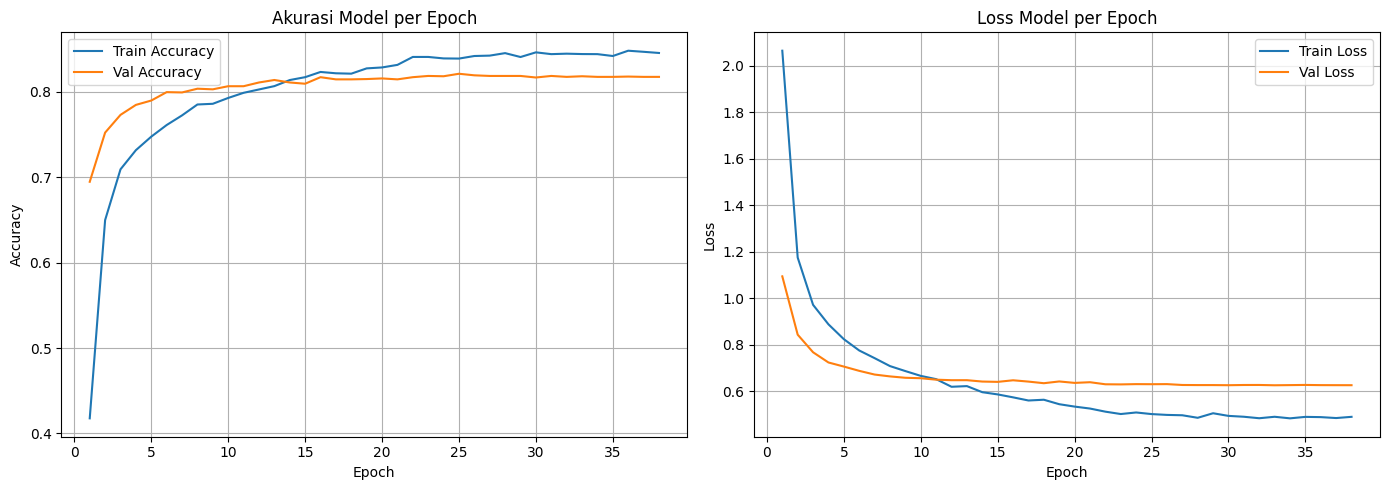

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Ambil label ground truth dan prediksi
y_true = []
y_pred = []

for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Buat report
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names  # Daftar nama kelas dari dataset
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

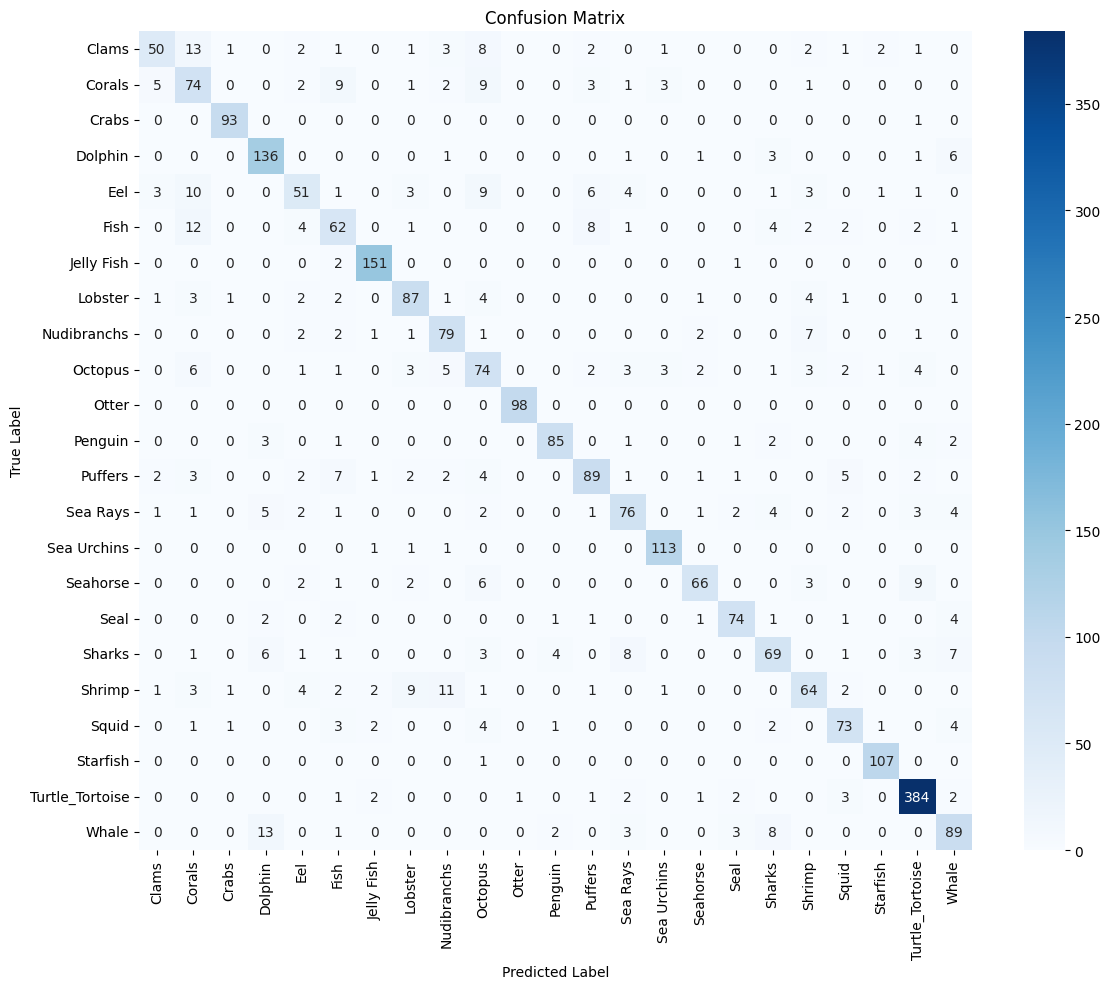

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ***✅ Langkah 7: Hasil Prediksi Gambar***

*Langkah terakhir ini memberikan visualisasi langsung terhadap prediksi model. Gambar dipilih secara acak dari data validasi, lalu ditampilkan bersama dengan label aslinya dan label hasil prediksi. Ini memberi pemahaman intuitif apakah model mengenali objek secara tepat dan seberapa sering kesalahan terjadi. Sangat membantu untuk validasi manual hasil klasifikasi.*

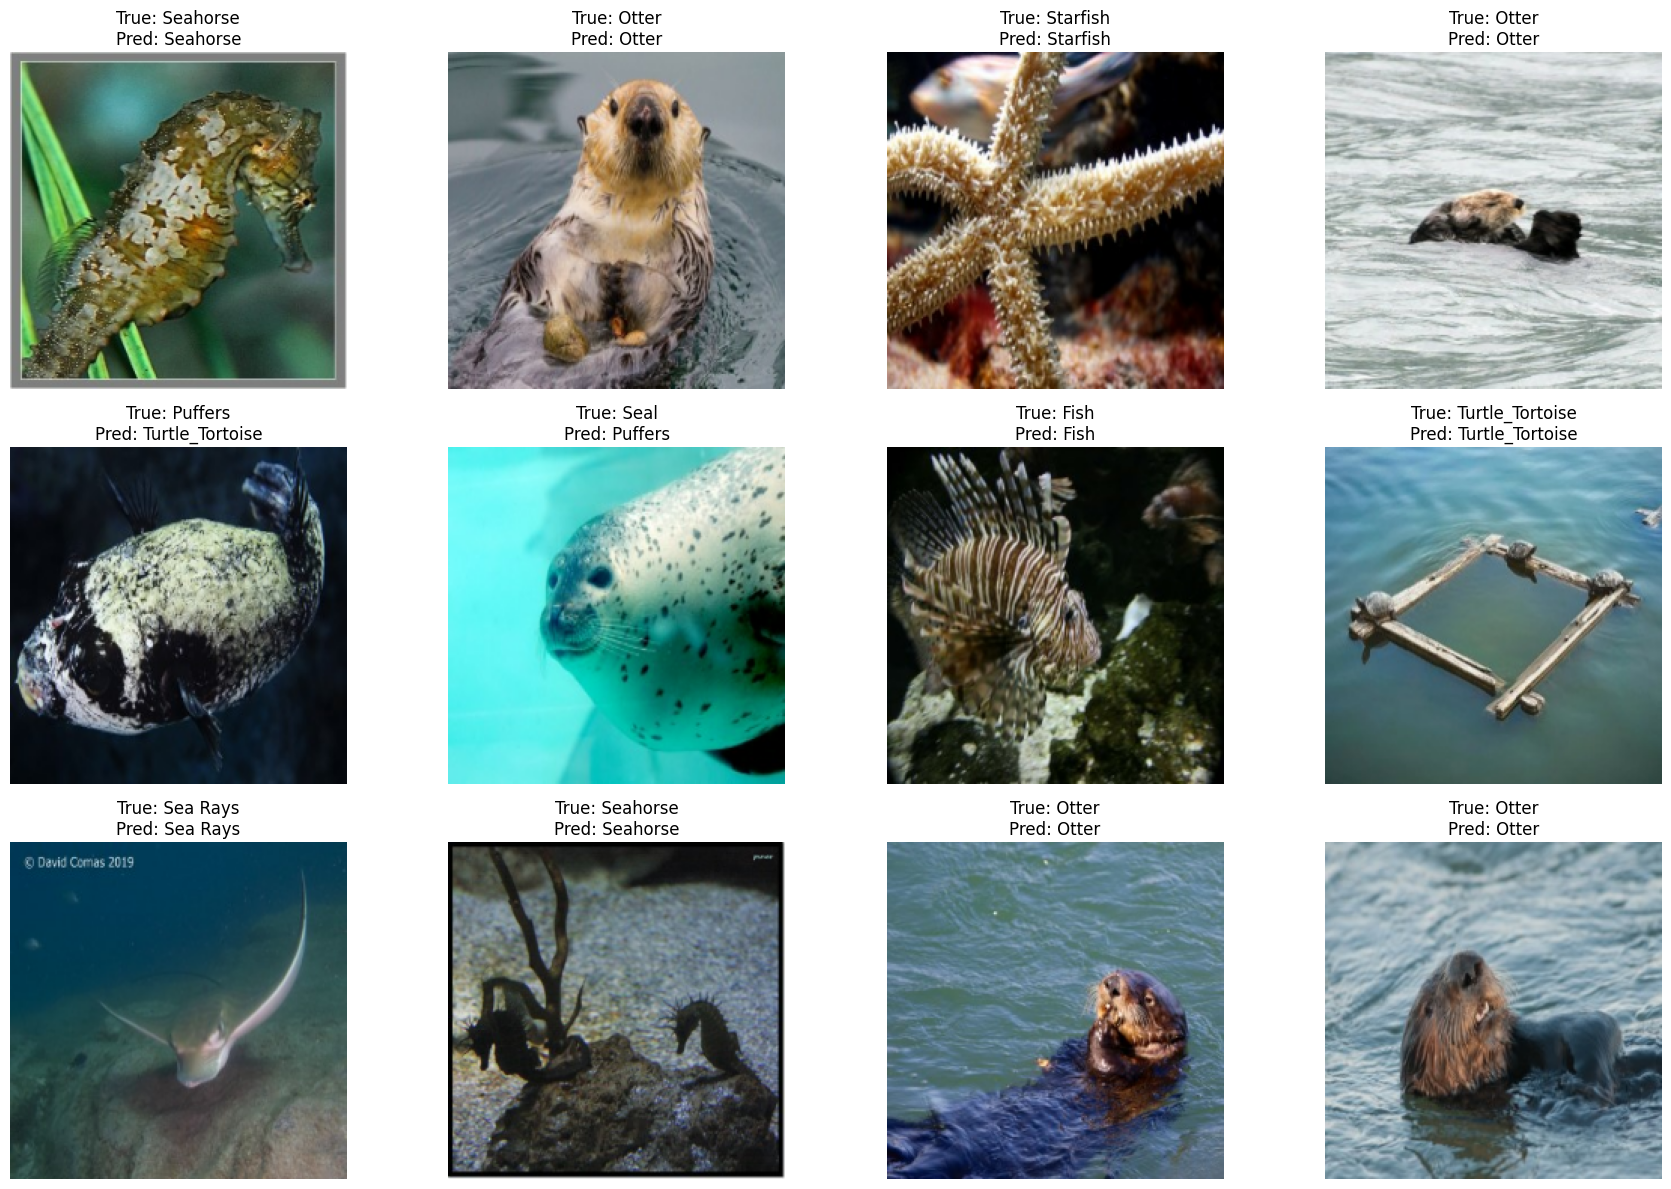

In [18]:
# Ambil nama kelas dari dataset
class_names = train_data.class_names

# Visualisasi 12 gambar prediksi model
plt.figure(figsize=(18, 12))  # Ukuran lebih besar agar cukup untuk 12 gambar

for i in range(12):
    for images, labels in val_data.take(1):
        idx = random.randint(0, len(images) - 1)
        img = images[idx]
        true_label = labels[idx].numpy()

        # Prediksi
        pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)
        pred_label = np.argmax(pred)

        # Plot gambar dan hasil prediksi
        plt.subplot(3, 4, i + 1)  # 3 baris x 4 kolom = 12 gambar
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")

plt.tight_layout()
plt.show()
